In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
data_path = "data/"

In [2]:
places = pd.read_csv(data_path + "places.csv", sep=";")
reviews = pd.read_csv(data_path + "reviews.csv", sep=";", low_memory=False)

## 1.2 Reviews

In [9]:
from datetime import datetime
import numpy as np
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
nltk.download("stopwords")
_stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jesperhauch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
print("Shape of reviews:", reviews.shape)
reviews.isna().sum()

Shape of reviews: (571724, 8)


rating                 0
reviewerName        2139
reviewText        146604
categories         50096
gPlusPlaceId        3885
unixReviewTime     49070
reviewTime         50817
gPlusUserId         5632
dtype: int64

In [19]:
# Categories is essential for our future analysis. Hence we remove rows with missing categories
reviews.dropna(subset=["categories"], inplace=True)

In [20]:
# Only get reviews that are in the places list
reviews = reviews.loc[lambda x: x.gPlusPlaceId.isin(places.gPlusPlaceId.values)]

In [21]:
reviews.dtypes

rating             object
reviewerName       object
reviewText         object
categories         object
gPlusPlaceId       object
unixReviewTime    float64
reviewTime         object
gPlusUserId        object
dtype: object

In [22]:
# Convert rating to numeric feature
reviews['rating'] = pd.to_numeric(reviews['rating'], downcast="integer")

In [23]:
# Using unix review time since it has less missing values and more information than the review time feature
def unixToDatetime(unix_timestamp):
    if not pd.isna(unix_timestamp):
        return datetime.utcfromtimestamp(unix_timestamp).strftime("%Y-%m-%d %H:%M:%S")
    else:
        return np.NaN

reviews['unixReviewTime'] = reviews['unixReviewTime'].apply(unixToDatetime)
reviews.drop(["reviewTime"], axis=1, inplace=True)

In [24]:
# Categories are stored as a "['Category']", thus we use regex to find the word between the apostrophes
reviews['categories'] = reviews.categories.apply(lambda x: re.findall(r"[\[|\s]\'(.*?)\'[\,|\]]", x))

In [25]:
# Text processing function from Social Graphs and Interactions
def cleanString(text):
    if not pd.isna(text):
        tokens = word_tokenize(text) #Tokenizing
        punctuation = [word.lower() for word in tokens if word.isalnum()] # remove punctuation and set to lower case
        lemma = [lemmatizer.lemmatize(word) for word in punctuation] # lemmatize words
        stopwords = stopwords.words('english')
        return [w for w in lemma if w not in stopwords] # Finally removes stopwords
    else:
        return np.NaN

In [26]:
#reviews['reviewTextClean'] = reviews['reviewText'].apply(cleanString)
#reviews.to_csv(data_path + "reviews_cleaned.csv", index=False)

# Exploratory (Reviews)

In [195]:
reviews = pd.read_csv(data_path + "reviews_cleaned.csv")
places = pd.read_csv(data_path + "places_cleaned.csv")

In [196]:
reviews['categories'] = reviews.categories.apply(lambda x: re.findall(r"[\[|\s]\'(.*?)\'[\,|\]]", x))

In [197]:
reviews.reviewTextClean[0]

"['cute', 'hotel', 'good', 'amenity', 'nice', 'location', 'great', 'cranky', 'cocktail', 'staff', 'hotel', 'bar', 'second', 'floor', 'ugh', 'last', 'thing', 'need', 'trying', 'unwind', 'tightly', 'wound', 'sour', 'cocktail', 'waitress', 'delivering', '18', 'drink']"

Each business has the same categories attached to it across reviews. To ensure we have as few categories as possible, we will find the most popular categories across all reviews and assign the most popular category of the categories each business belongs to.

In [198]:
def findPopularCat(df):
    popular_dict = df.explode(column = "categories").groupby(["categories"]).count()['gPlusUserId'].to_dict()
    temp_df = df.drop_duplicates(subset="gPlusPlaceId").reset_index(drop=True)
    category_dict = {}
    for _, row in temp_df.iterrows():
        max_count = 0
        max_cat = ""
        for cat in row['categories']:
            count = popular_dict[cat]
            if count > max_count:
                max_count = count
                max_cat = cat
        category_dict[row['gPlusPlaceId']] = max_cat
    return category_dict

In [199]:
category_dict = findPopularCat(reviews)
places['category'] = places['gPlusPlaceId'].apply(lambda x: category_dict[x] if x in category_dict.keys() else np.NAN)

In [201]:
s = places.category.str.contains("Restaurant").values
restaurants = places.loc[np.nonzero(s)[0]].reset_index(drop=True)
restaurants[restaurants.price == 2].sample(10)

,gPlusPlaceId,name,price,lat,lon,city,address,category
3938,115907789527187073270,India Cottage,2.0,51.469479,-0.210033,London,"['67 Fulham High St', 'London SW6 3JJ', 'Unite...",Asian Restaurant
10954,103450930933542342454,Angelo's Pizza,2.0,40.764887,-73.977958,New York,"['117 W 57th St', 'New York, NY 10019']",European Restaurant
7523,111123327984327241090,Guilty Goose,2.0,40.743503,-73.993862,New York,"['131 W 23rd St', 'New York, NY 10011']",American Restaurant
9732,118007553844264644832,Giorgio's of Gramercy,2.0,40.739635,-73.988696,New York,"['27 E 21st St', 'New York, NY 10010']",American Restaurant
4613,100580407174845512351,Grill 212,2.0,40.784161,-73.978794,New York,"['212 W 80th St', 'New York, NY 10024']",Middle Eastern Restaurant
8298,102485927097406951073,Soup Spot,2.0,40.749522,-73.993233,New York,"['220 W 31st St #2', 'New York, NY 10001']",Restaurant
6743,106433740781339566494,Buona Notte,2.0,40.717836,-73.998030,New York,"['120 Mulberry St #1', 'New York, NY 10013']",Italian Restaurant
6084,115396141141975013836,Agave,2.0,40.734729,-74.002374,New York,"['140 7th Ave S', 'New York, NY 10014']",Mexican Restaurant
3843,103200262396361416461,Yoshi Sushi,2.0,40.726882,-73.983088,New York,"['131 Avenue A', 'New York, NY 10009']",Asian Restaurant
978,115418647207174673879,Khe-yo,2.0,40.716853,-74.008651,New York,"['157 Duane St', 'New York, NY 10013']",Laotian Restaurant


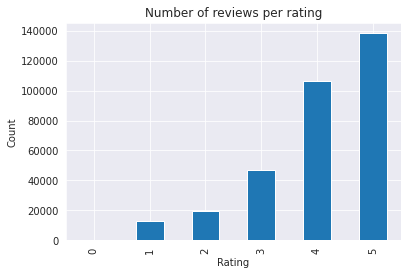

In [97]:
# Fjerne 0 rækker i reviews
reviews.rating.value_counts().sort_index().plot.bar(xlabel="Rating", ylabel="Count", title="Number of reviews per rating");

In [174]:
reviews.reviewTextClean[0]

"['cute', 'hotel', 'good', 'amenity', 'nice', 'location', 'great', 'cranky', 'cocktail', 'staff', 'hotel', 'bar', 'second', 'floor', 'ugh', 'last', 'thing', 'need', 'trying', 'unwind', 'tightly', 'wound', 'sour', 'cocktail', 'waitress', 'delivering', '18', 'drink']"

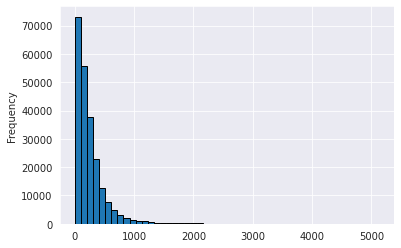

In [171]:
# Distribution of the amount of characters in the reviews
reviews.dropna(subset=["reviewTextClean"]).reviewTextClean.apply(len).plot.hist(bins=50, edgecolor="black");

<AxesSubplot:xlabel='unixReviewTime'>

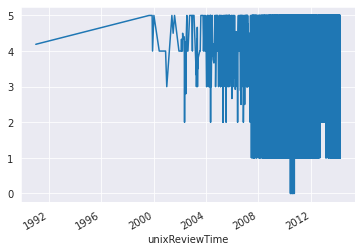

In [100]:
# fjern alt før 2000
temp_df = reviews.dropna(subset="unixReviewTime")
temp_df['unixReviewTime'] = pd.to_datetime(reviews['unixReviewTime'])
temp_df.groupby("unixReviewTime").mean()['rating'].sort_index().plot()